In [1]:
import matplotlib.pyplot as plt

from glob import glob

import numpy as np
import cv2 as cv

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader #,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F

import torchvision
# from torchvision import datasets,transforms
# import torchvision.transforms as transforms

from tqdm.notebook import tqdm

# import optuna

# import wandb

import pickle5 as pickle

from convAE_test import Encoder, Decoder

import sys
sys.path.append("..")

from util.util_main import get_filename_from_dir, get_dataset_dir
from notebooks.visualization_helpers import get_stage3_products

from astropy.io import fits

import random

In [2]:
class InjectionDataset(Dataset):
    def __init__(self):
        PROPOSAL_ID = '1386'
        INSTRUMENT = 'NIRCAM'
        self.real_psfs_dir = f'/data/scratch/bariskurtkaya/dataset/{INSTRUMENT}/{PROPOSAL_ID}/mastDownload/JWST/'

        self.class_map = {'star_only' : 0, 'star_exo': 1}
        self.img_dim = (320, 320)


        #self.real_psfstacks = {}
        self.real_psfstacks = []
        self.injected_psfs = []

        self.__prepare_real_psf()
        self.__prepare_injected_psf()

        self.real_psfstacks, self.injected_psfs = np.array(self.real_psfstacks), np.array(self.injected_psfs)

        self.data = np.concatenate((self.real_psfstacks, self.injected_psfs), axis=0)

        for _, psf in enumerate(self.data):
            psf[0] = (psf[0] - np.min(psf[0])) / (np.max(psf[0])- np.min(psf[0]))


    def __len__(self):
        return self.data.shape[0]

    def __create_psfstacks_dict(self) -> None:
        for _, dir in enumerate(self.psfstacks_nircam_dirs):
            fits_name = get_filename_from_dir(dir)
            #self.real_psfstacks[fits_name] = fits.open(dir)[1].data
            psfstack = fits.open(dir)[1].data

            for _, psf in enumerate(psfstack):
                self.real_psfstacks.append([psf, 'star_only'])

            del fits_name

    def __prepare_real_psf(self) -> None:
        self.psfstacks_nircam_dirs = get_stage3_products(
            suffix='psfstack', directory=self.real_psfs_dir)

        self.__create_psfstacks_dict()

    def __prepare_injected_psf(self) -> None:
        injected_psfs_dir = glob(f'{get_dataset_dir()}/PSF_INJECTION/*.png')

        for _, dir in enumerate(injected_psfs_dir):
            #self.injected_psfs.append([ dir.split('/')[-1], cv.imread(dir, 0)])
            self.injected_psfs.append([cv.imread(dir, 0), 'star_exo'])

    def __getitem__(self, idx):
        psf_img, class_name = self.data[idx]

        psf_img = np.nan_to_num(psf_img)

        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(psf_img)

        img_tensor = img_tensor.float()

        #img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id



In [3]:
dataset = InjectionDataset()


KeyboardInterrupt: 

In [ ]:
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
with open("/data/scratch/bariskurtkaya/dataset/models_injection/249_enc.pickle", "rb") as fin:
    enc_best = pickle.load(fin).to(device)
    
with open("/data/scratch/bariskurtkaya/dataset/models_injection/249_dec.pickle", "rb") as fin:
    dec_best = pickle.load(fin).to(device)

In [6]:
enc_best = enc_best.to(device)
dec_best = dec_best.to(device)

In [11]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [28]:
test_epoch(enc_best, dec_best, device, train_loader, loss_fn = torch.nn.MSELoss())


KeyboardInterrupt: 

In [ ]:
test_loader = train_loader

In [31]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

enc_best.eval()
dec_best.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = enc_best(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(50, 128)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = dec_best(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:50],10,5))
    plt.show()

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

RuntimeError: The size of tensor a (128) must match the size of tensor b (1000) at non-singleton dimension 1

In [ ]:
img = cv.imread(f'/data/scratch/bariskurtkaya/dataset/PSF_INJECTION/jw01386-a3001_t004_nircam_f300m-maskrnd-sub320a335r-psf107-x301-y22-fc1.png', 0)
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.float()
img_tensor = img_tensor.view((-1, 320, 320))
img_tensor.shape

torch.Size([1, 320, 320])

In [7]:
def plot_ae_outputs(encoder,decoder, n=10):
    plt.figure(figsize=(16,4.5))
    #targets = test_dataset.targets.numpy()
    #t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}

    dataset_dir = '/data/scratch/bariskurtkaya/dataset/PSF_INJECTION/'
    img_dirs = glob(dataset_dir+'*.png')

    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        
        img_dir = random.choice(img_dirs)
        img = cv.imread(f'{img_dir}', 0)
        print(img_dir.split('/')[-1])

        img = (img - np.min(img)) / (np.max(img)- np.min(img))
        
        #noise = np.random.normal(0,60,img.shape)
        #img = img + noise

        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.float()
        img_tensor = img_tensor.view((-1, 320, 320))
        img_tensor = img_tensor.to(device)
        
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img_tensor))
        #plt.imshow(np.arcsinh(img_tensor.cpu().squeeze().numpy()))
        plt.imshow(img_tensor.cpu().squeeze().numpy())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        #plt.imshow(np.arcsinh(rec_img.cpu().squeeze().numpy()))
        plt.imshow(rec_img.cpu().squeeze().numpy())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show() 

jw01386-a3001_t004_nircam_f360m-maskrnd-sub320a335r-psf266-x126-y162-fc10000.png
jw01386-a3001_t002_nircam_f300m-maskrnd-sub320a335r-psf11-x66-y37-fc10000.png
jw01386-a3001_t004_nircam_f356w-maskrnd-sub320a335r-psf11-x309-y241-fc100.png
jw01386-a3001_t004_nircam_f300m-maskrnd-sub320a335r-psf237-x180-y24-fc100.png
jw01386-a3001_t004_nircam_f300m-maskrnd-sub320a335r-psf424-x300-y5-fc10000.png
jw01386-a3001_t004_nircam_f300m-maskrnd-sub320a335r-psf387-x206-y7-fc2.png
jw01386-a3001_t004_nircam_f360m-maskrnd-sub320a335r-psf186-x236-y88-fc10000.png
jw01386-a3001_t004_nircam_f360m-maskrnd-sub320a335r-psf178-x240-y17-fc1.png
jw01386-a3001_t004_nircam_f300m-maskrnd-sub320a335r-psf119-x36-y133-fc10.png
jw01386-a3001_t004_nircam_f300m-maskrnd-sub320a335r-psf212-x173-y282-fc100.png


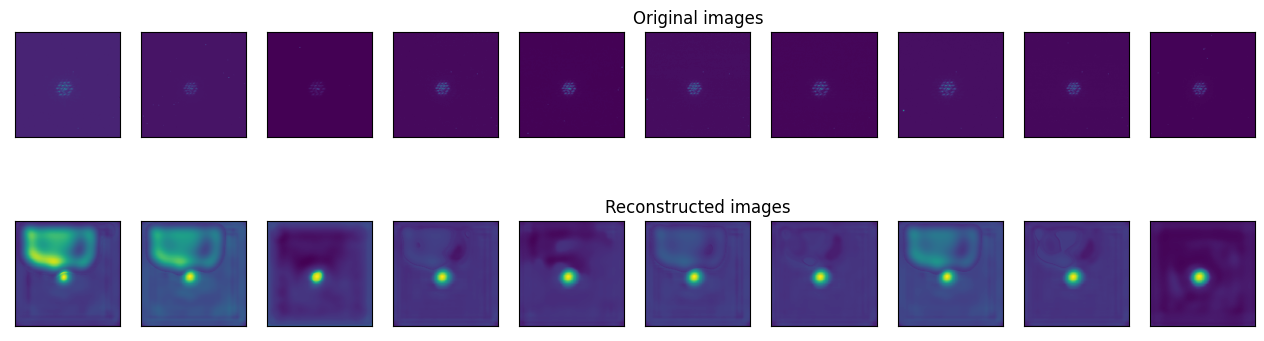

In [9]:
plot_ae_outputs(enc_best,dec_best, n=10)

In [ ]:
import pandas as pd

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    enc_best.eval()
    with torch.no_grad():
        encoded_img  = enc_best(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

In [ ]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()